In [92]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import scale
from sklearn.cross_validation import train_test_split
from keras import models
from keras import layers
import matplotlib.pyplot as plt
%matplotlib inline


In [93]:
test = pd.read_csv("/Users/thomascurran/desktop/MACS30200proj2/Data/ms_clean.csv").drop("Unnamed: 0", axis = 1)

In [94]:
test['Year'] = test['Year'].astype('category')

In [95]:
test2 = test.select_dtypes(include = ['int', 'float'])

In [96]:
y = test2['IndexScore']
x = test2.iloc[:,1:len(test2)]
xtrain, xtest, ytrain, ytest = train_test_split(x,y, train_size = .76, random_state = 25)

In [97]:
from sklearn.preprocessing import normalize, scale

'''
Parameters:	
X : {array-like, sparse matrix}

The data to center and scale.

axis : int (0 by default)

axis used to compute the means and standard deviations along. If 0, independently standardize each feature, otherwise (if 1) standardize each sample.

with_mean : boolean, True by default

If True, center the data before scaling.

with_std : boolean, True by default

If True, scale the data to unit variance (or equivalently, unit standard deviation).

copy : boolean, optional, default True

set to False to perform inplace row normalization and avoid a copy (if the input is already a numpy array or a scipy.sparse CSC matrix and if axis is 1).


'''

xtrain2 = xtrain.copy()
for i in range(0, len(xtrain.columns)):
    a = scale(xtrain2.iloc[:,i], with_mean = True, with_std = True)
    xtrain2.iloc[:,i] = a
   
    

In [98]:

ytrain = scale(ytrain, with_mean = True, with_std = True)


In [99]:
#xtrain = xtrain.values
#xtest = xtest.values
#ytrain = ytrain.values
#ytest = ytest.values

In [100]:
def kfold_cv(func, k = 4, epochs = 10, batch = 1):
    all_mae_histories = []
    all_mse_histories = []
    num_val_samples = len(xtrain)//k
    
    
    for i in range(0,k):
        print('processing fold #', i)
        
        val_data = xtrain[i * num_val_samples: (i + 1) * num_val_samples]    
        
        val_targets = ytrain[i * num_val_samples: (i + 1) * num_val_samples]
        
        partial_train_data = np.concatenate(                                     
            [xtrain[:i * num_val_samples],
             xtrain[(i + 1) * num_val_samples:]],
            axis=0)
        
        partial_train_targets = np.concatenate(
            [ytrain[:i * num_val_samples],
             ytrain[(i + 1) * num_val_samples:]],
            axis=0)

        model = func()                                                    
       
        history = model.fit(partial_train_data, 
                            partial_train_targets,           
                            validation_data=(val_data, val_targets),
                            epochs=epochs, 
                            batch_size=batch, 
                            verbose=0)
        
        mae_history = history.history['val_mean_absolute_error']
        all_mae_histories.append(mae_history)
       
        mse_history = history.history['val_loss']
        all_mse_histories.append(mse_history)
        
    return(all_mae_histories, 
               all_mse_histories, 
               xtrain,
               ytrain,
               model, 
               history)

In [101]:
#Produces the MAE plot for each model
def mae_plot(mses, epochs):
    avg_mae = [np.mean([x[i] for x in mses]) for i in range(epochs)]
    plt.figure(figsize = (10,10))
    plt.plot(range(1, len(avg_mae) + 1), avg_mae)
    plt.xlabel('Epochs')
    plt.ylabel('Validation MSE')
    plt.show()

In [102]:

#prints the MSE and MAE for each Model#prints t 
def model_metrics(test_data, test_targets, model):
    mse, mae = model.evaluate(test_data, test_targets)
    print("MSE For Test Set: ", mse)
    print("MAE For Test Set: ", mae)

In [103]:
#function that passes in the data to all the other functions
def q3(model, k=10, epochs = 10, batch = 1):
    mae_scores, mse_scores, test_data, test_targets, model_train, model_history = kfold_cv(model, k, epochs, batch)
    mae_plot(mse_scores, epochs)
    model_metrics(test_data, test_targets, model_train)
    return(mae_scores, mse_scores)

In [104]:
from keras import regularizers

processing fold # 0
processing fold # 1
processing fold # 2
processing fold # 3
processing fold # 4
processing fold # 5
processing fold # 6
processing fold # 7
processing fold # 8
processing fold # 9


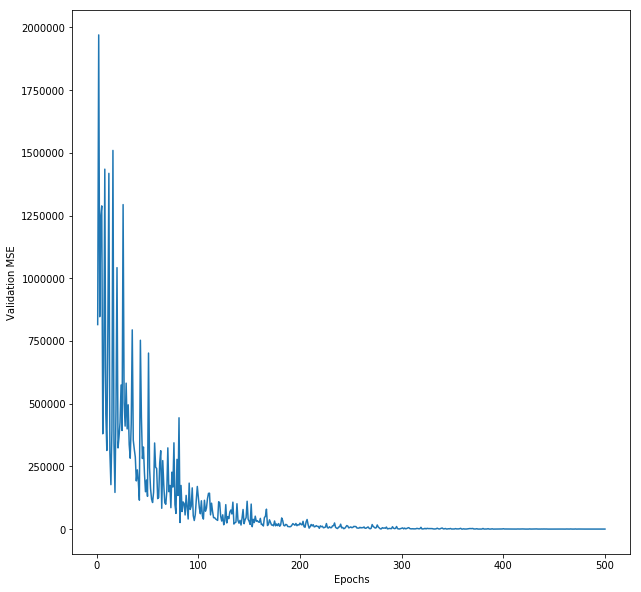

675/675 [==============================] - 0s 32us/step
MSE For Test Set:  933.531499747
MAE For Test Set:  28.803267551


In [105]:
K = 10
epochs = 500
batch = 50

def baseline():
    model = models.Sequential()
    
    model.add(layers.Dense(64, 
                           activation='relu',
                           input_shape=(xtrain.shape[1],)))
    
    model.add(layers.Dense(64, 
                           activation='relu'))
    
    model.add(layers.Dense(1))
    
    model.compile(optimizer='rmsprop', 
                  loss='mse', 
                  metrics=['mae'])
    return model

baseline_mae, baseline_mses = q3(baseline, K, epochs, batch)

In [111]:
xtest2 = xtest.copy()
for i in range(0, len(xtest2.columns)):
    a = scale(xtest2.iloc[:,i], with_mean = True, with_std = True)
    xtest2.iloc[:,i] = a
   

In [112]:
ytest2 = ytest.copy()
ytest2 = scale(ytest2, with_mean = True, with_std = True)

In [115]:
model = baseline()

model.fit(xtrain2,ytrain, epochs=200, batch_size=15, verbose=0)

In [116]:
model.evaluate(xtrain2, ytrain)

675/675 [==============================] - 0s 351us/step


[0.0042031998130389386, 0.044950045744578046]

In [118]:
a = model.predict(xtest2)

In [119]:
b = ytest

In [122]:
c = pd.DataFrame(a)

In [128]:
c['b'] = ytest2

In [138]:
(c.b[2] * ytest.std()) +ytest.mean()

67.98494590958606

In [152]:
c['reality'] = np.array(ytest)
c['predicted'] = round((c['b'] * ytest.std()) + ytest.mean())
c

,0,b,reality,predicted
0,0.387043,0.320935,78.0,78.0
1,0.281148,0.679577,82.0,82.0
2,-0.174344,-0.575671,68.0,68.0
3,-0.291965,-0.306690,71.0,71.0
4,0.956292,1.307201,89.0,89.0
5,0.249188,0.320935,78.0,78.0
6,0.528691,0.051953,75.0,75.0
7,-0.204400,-0.127368,73.0,73.0
8,-0.099728,0.410595,79.0,79.0
9,0.723752,0.589916,81.0,81.0
